# List of project's dependencies
Below are listed imports that are needed for program to work properly commented with required install (see also requirements.txt)

In [1]:
#List of imports
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import sys
sys.path.append('../../code')
from functions import *
from torchviz import make_dot
from torchsummary import summary

### Training process
We defined function to help with training process

In [3]:
def train(model, criterion, optimizer, num_epochs, batch_size, best_val_loss, max_no_learn_epochs):
    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]

        # Forward pass
            outputs = model(batch_X).to(device)
            loss = criterion(outputs, batch_y)

        # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation step
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_validate)
            val_loss = criterion(val_outputs, y_validate)


    # Check if this is the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_model_state = model.state_dict()
            no_learn_epochs_count = 0
        elif no_learn_epochs_count < max_no_learn_epochs:
            no_learn_epochs_count += 1
        else:
            break
    
    # Print progress
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return best_val_loss,best_epoch,best_model_state

# Model creation, training and evaluations
## Price prediction

In [2]:
X_train, X_test, y_train, y_test = price_preprocessing()
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# Compute on CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = torch.tensor(np.array(X_train), dtype=torch.float32).to(device)
X_test  = torch.tensor(np.array(X_test), dtype=torch.float32).to(device)
X_validate = torch.tensor(np.array(X_validate), dtype=torch.float32).to(device)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32).reshape(-1, 1).to(device)
y_test  = torch.tensor(np.array(y_test), dtype=torch.float32).reshape(-1, 1).to(device)
y_validate  = torch.tensor(np.array(y_validate), dtype=torch.float32).reshape(-1, 1).to(device)

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
input_size = X_train.shape[1]
hidden_size = 100
output_size = 1

model = MLP(input_size, hidden_size, output_size).to(device)

summary(model, input_size=(1, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]           3,900
              ReLU-2               [-1, 1, 100]               0
            Linear-3                 [-1, 1, 1]             101
Total params: 4,001
Trainable params: 4,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [5]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

#Training the model
num_epochs = 100
batch_size = 50
best_val_loss = float('inf')
best_epoch = -1
best_model_state = None
no_learn_epochs_count = 0
max_no_learn_epochs = 10

best_val_loss, best_epoch, best_model_state = train(
    model, 
    criterion, 
    optimizer, 
    num_epochs, 
    batch_size,
    best_val_loss, 
    max_no_learn_epochs
)

model.load_state_dict(best_model_state)
print(f'Loaded best model from epoch {best_epoch+1} with validation loss: {best_val_loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test)
    test_loss = criterion(y_pred_tensor, y_test)
    print('Test Loss:', test_loss.item())

# Convert predictions and true labels back to numpy arrays
y_pred_tensor_cpu = y_pred_tensor.to("cpu")
y_pred = y_pred_tensor_cpu.numpy()
y_true = y_test.to("cpu").numpy()

Epoch [10/100], Loss: 21086707712.0000
Epoch [20/100], Loss: 22355021824.0000
Epoch [30/100], Loss: 22434134016.0000
Epoch [40/100], Loss: 22295693312.0000
Epoch [50/100], Loss: 22261936128.0000
Epoch [60/100], Loss: 22209583104.0000
Epoch [70/100], Loss: 22173782016.0000
Epoch [80/100], Loss: 22139553792.0000
Epoch [90/100], Loss: 22141159424.0000
Epoch [100/100], Loss: 22136995840.0000
Loaded best model from epoch 100 with validation loss: 20310374400.0000
Test Loss: 19898089472.0


MSE: 19898087424.0
MAE: 104918.0
R-squared: 0.69


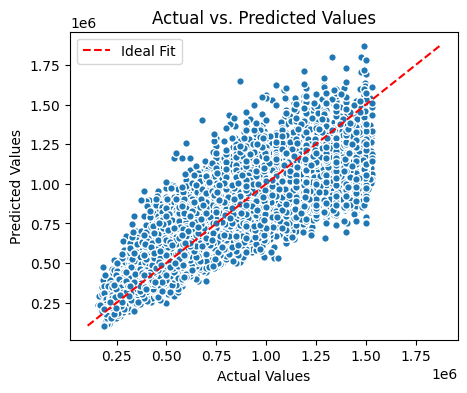

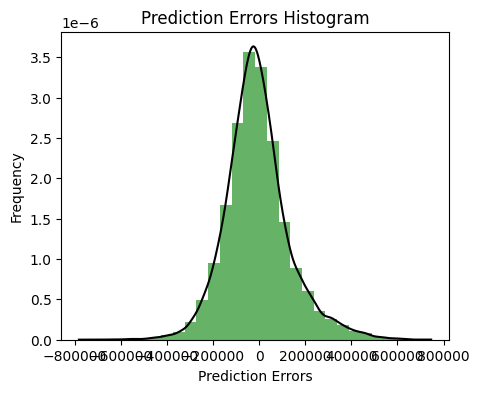

In [6]:
evaluate_model(
    true_data=np.asarray(y_test.to("cpu")).flatten(), 
    predicted_data=np.asarray(y_pred).flatten()
)

In [7]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
# Initialize the model
input_size = X_train.shape[1]
hidden_size1 = 100
hidden_size2 = 150
hidden_size3 = 70
hidden_size4 = 20
output_size = 1

model = MLP(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size).to(device)

summary(model, input_size=(1, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]           3,900
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 150]          15,150
              ReLU-4               [-1, 1, 150]               0
            Linear-5                [-1, 1, 70]          10,570
              ReLU-6                [-1, 1, 70]               0
            Linear-7                [-1, 1, 20]           1,420
              ReLU-8                [-1, 1, 20]               0
            Linear-9                 [-1, 1, 1]              21
Total params: 31,061
Trainable params: 31,061
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.12
Estimated Total Size (MB): 0.12
---------------------------------------------

In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

#Training the model
num_epochs = 200
batch_size = 40
best_val_loss = float('inf')
best_epoch = -1
best_model_state = None
no_learn_epochs_count = 0
max_no_learn_epochs = 16

best_val_loss, best_epoch, best_model_state = train(
    model, 
    criterion, 
    optimizer, 
    num_epochs, 
    batch_size,
    best_val_loss, 
    max_no_learn_epochs
)

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test)
    test_loss = criterion(y_pred_tensor, y_test)
    print('Test Loss:', test_loss.item())

# Convert predictions and true labels back to numpy arrays
y_pred_tensor_cpu = y_pred_tensor.to("cpu")
y_pred = y_pred_tensor_cpu.numpy()
y_true = y_test.to("cpu").numpy()

Epoch [10/200], Loss: 9342351360.0000
Epoch [20/200], Loss: 9558003712.0000
Epoch [30/200], Loss: 9300721664.0000
Epoch [40/200], Loss: 9949490176.0000
Epoch [50/200], Loss: 10538510336.0000
Epoch [60/200], Loss: 10676944896.0000
Epoch [70/200], Loss: 9378701312.0000
Epoch [80/200], Loss: 9539280896.0000
Epoch [90/200], Loss: 9100492800.0000
Epoch [100/200], Loss: 9541525504.0000
Epoch [110/200], Loss: 9673571328.0000
Epoch [120/200], Loss: 9110022144.0000
Test Loss: 15879837696.0


MSE: 15879837696.0
MAE: 93759.59375
R-squared: 0.78


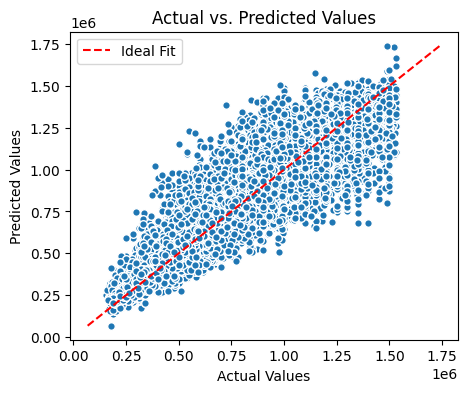

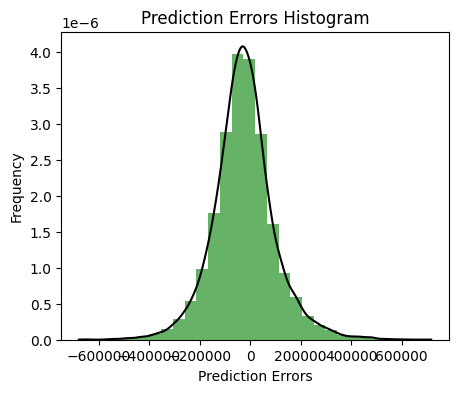

In [9]:
evaluate_model(
    true_data=np.asarray(y_test.to("cpu")).flatten(), 
    predicted_data=np.asarray(y_pred).flatten()
)

In [10]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, hidden_size6, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.fc6 = nn.Linear(hidden_size5, hidden_size6)
        self.fc7 = nn.Linear(hidden_size6, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.fc7(x)
        return x
    
# Initialize the model
input_size = X_train.shape[1]
hidden_size1 = 100
hidden_size2 = 150
hidden_size3 = 100
hidden_size4 = 85
hidden_size5 = 50
hidden_size6 = 10
output_size = 1

model = MLP(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, hidden_size6, output_size).to(device)

summary(model, input_size=(1, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]           3,900
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 150]          15,150
              ReLU-4               [-1, 1, 150]               0
            Linear-5               [-1, 1, 100]          15,100
              ReLU-6               [-1, 1, 100]               0
            Linear-7                [-1, 1, 85]           8,585
              ReLU-8                [-1, 1, 85]               0
            Linear-9                [-1, 1, 50]           4,300
             ReLU-10                [-1, 1, 50]               0
           Linear-11                [-1, 1, 10]             510
             ReLU-12                [-1, 1, 10]               0
           Linear-13                 [-1, 1, 1]              11
Total params: 47,556
Trainable params: 

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

#Training the model
num_epochs = 500
batch_size = 50
best_val_loss = float('inf')
best_epoch = -1
best_model_state = None
no_learn_epochs_count = 0
max_no_learn_epochs = 16

best_val_loss, best_epoch, best_model_state = train(
    model, 
    criterion, 
    optimizer, 
    num_epochs, 
    batch_size,
    best_val_loss, 
    max_no_learn_epochs
)

model.load_state_dict(best_model_state)
print(f'Loaded best model from epoch {best_epoch+1} with validation loss: {best_val_loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test)
    test_loss = criterion(y_pred_tensor, y_test)
    print('Test Loss:', test_loss.item())

# Convert predictions and true labels back to numpy arrays
y_pred_tensor_cpu = y_pred_tensor.to("cpu")
y_pred = y_pred_tensor_cpu.numpy()
y_true = y_test.to("cpu").numpy()


Epoch [10/500], Loss: 18143356928.0000
Epoch [20/500], Loss: 16926285824.0000
Epoch [30/500], Loss: 16243973120.0000
Loaded best model from epoch 17 with validation loss: 18210830336.0000
Test Loss: 18221297664.0


MSE: 18221295616.0
MAE: 101621.65625
R-squared: 0.77


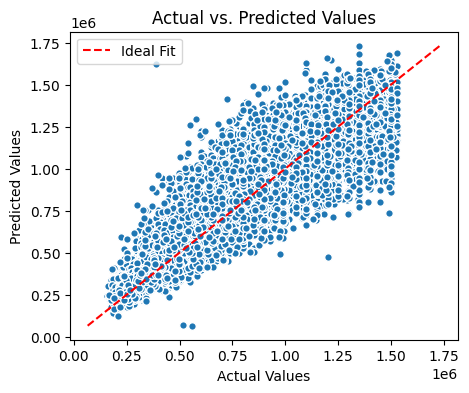

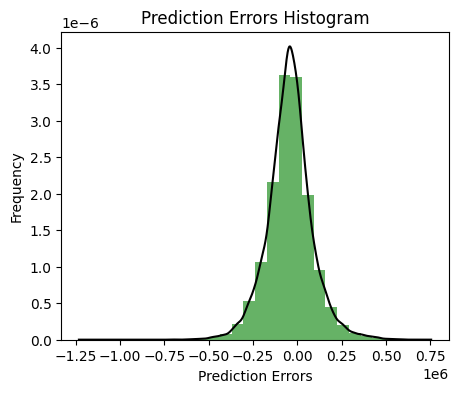

In [12]:
evaluate_model(
    true_data=np.asarray(y_test.to("cpu")).flatten(), 
    predicted_data=np.asarray(y_pred).flatten()
)

## Rent prediction

In [13]:
X_train, X_test, y_train, y_test = rent_preprocessing()
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# Compute on CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = torch.tensor(np.array(X_train), dtype=torch.float32).to(device)
X_test  = torch.tensor(np.array(X_test), dtype=torch.float32).to(device)
X_validate = torch.tensor(np.array(X_validate), dtype=torch.float32).to(device)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32).reshape(-1, 1).to(device)
y_test  = torch.tensor(np.array(y_test), dtype=torch.float32).reshape(-1, 1).to(device)
y_validate  = torch.tensor(np.array(y_validate), dtype=torch.float32).reshape(-1, 1).to(device)

In [14]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
input_size = X_train.shape[1]
hidden_size = 100
output_size = 1

model = MLP(input_size, hidden_size, output_size).to(device)

summary(model, input_size=(1, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]           3,700
              ReLU-2               [-1, 1, 100]               0
            Linear-3                 [-1, 1, 1]             101
Total params: 3,801
Trainable params: 3,801
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [15]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

#Training the model
num_epochs = 100
batch_size = 50
best_val_loss = float('inf')
best_epoch = -1
best_model_state = None
no_learn_epochs_count = 0
max_no_learn_epochs = 10

best_val_loss, best_epoch, best_model_state = train(
    model, 
    criterion, 
    optimizer, 
    num_epochs, 
    batch_size,
    best_val_loss, 
    max_no_learn_epochs
)


model.load_state_dict(best_model_state)
print(f'Loaded best model from epoch {best_epoch+1} with validation loss: {best_val_loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test)
    test_loss = criterion(y_pred_tensor, y_test)
    print('Test Loss:', test_loss.item())

# Convert predictions and true labels back to numpy arrays
y_pred_tensor_cpu = y_pred_tensor.to("cpu")
y_pred = y_pred_tensor_cpu.numpy()
y_true = y_test.to("cpu").numpy()

Epoch [10/100], Loss: 516441.7188
Epoch [20/100], Loss: 496975.3750
Epoch [30/100], Loss: 427928.0312
Epoch [40/100], Loss: 400681.1250
Epoch [50/100], Loss: 368385.0625
Epoch [60/100], Loss: 356891.7812
Epoch [70/100], Loss: 366292.8125
Epoch [80/100], Loss: 361875.1250
Epoch [90/100], Loss: 364506.6250
Epoch [100/100], Loss: 358273.6250
Loaded best model from epoch 100 with validation loss: 406001.6562
Test Loss: 422923.75


MSE: 422923.8125
MAE: 487.5899963378906
R-squared: 0.71


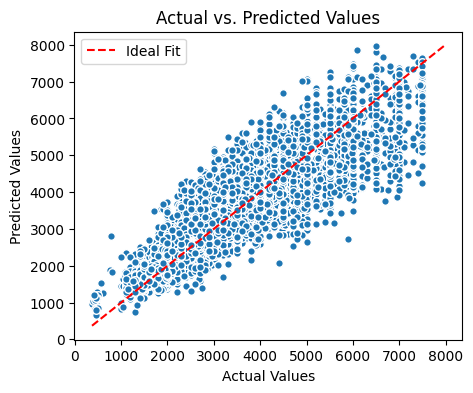

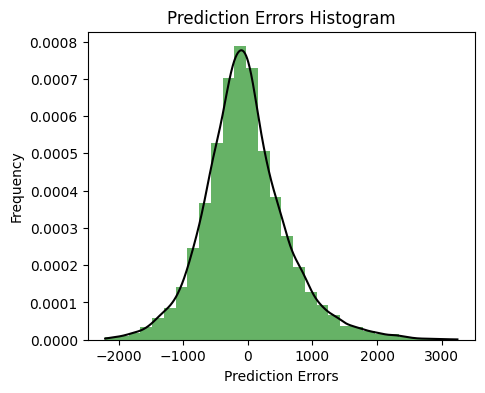

In [16]:
evaluate_model(
    true_data=np.asarray(y_test.to("cpu")).flatten(), 
    predicted_data=np.asarray(y_pred).flatten()
)

In [17]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
# Initialize the model
input_size = X_train.shape[1]
hidden_size1 = 100
hidden_size2 = 150
hidden_size3 = 70
hidden_size4 = 20
output_size = 1

model = MLP(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size).to(device)

summary(model, input_size=(1, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]           3,700
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 150]          15,150
              ReLU-4               [-1, 1, 150]               0
            Linear-5                [-1, 1, 70]          10,570
              ReLU-6                [-1, 1, 70]               0
            Linear-7                [-1, 1, 20]           1,420
              ReLU-8                [-1, 1, 20]               0
            Linear-9                 [-1, 1, 1]              21
Total params: 30,861
Trainable params: 30,861
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.12
Estimated Total Size (MB): 0.12
---------------------------------------------

In [18]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

#Training the model
num_epochs = 200
batch_size = 40
best_val_loss = float('inf')
best_epoch = -1
best_model_state = None
no_learn_epochs_count = 0
max_no_learn_epochs = 16

best_val_loss, best_epoch, best_model_state = train(
    model, 
    criterion, 
    optimizer, 
    num_epochs, 
    batch_size,
    best_val_loss, 
    max_no_learn_epochs
)

model.load_state_dict(best_model_state)
print(f'Loaded best model from epoch {best_epoch+1} with validation loss: {best_val_loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test)
    test_loss = criterion(y_pred_tensor, y_test)
    print('Test Loss:', test_loss.item())

# Convert predictions and true labels back to numpy arrays
y_pred_tensor_cpu = y_pred_tensor.to("cpu")
y_pred = y_pred_tensor_cpu.numpy()
y_true = y_test.to("cpu").numpy()

Epoch [10/200], Loss: 252428.7188
Loaded best model from epoch 3 with validation loss: 469771.7188
Test Loss: 523825.625


MSE: 523825.625
MAE: 525.3099975585938
R-squared: 0.57


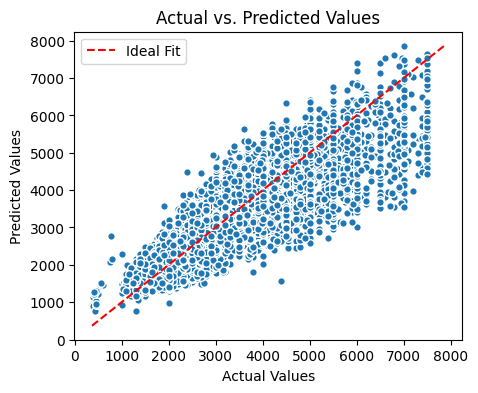

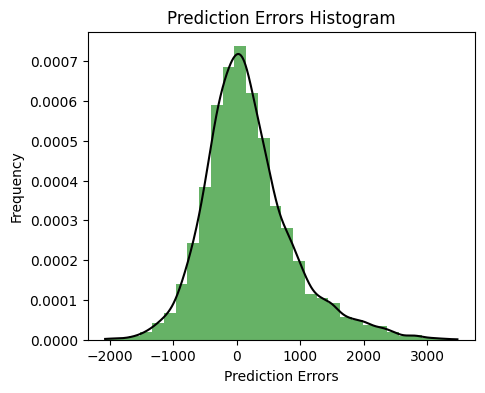

In [19]:
evaluate_model(
    true_data=np.asarray(y_test.to("cpu")).flatten(), 
    predicted_data=np.asarray(y_pred).flatten()
)

In [20]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, hidden_size6, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.fc6 = nn.Linear(hidden_size5, hidden_size6)
        self.fc7 = nn.Linear(hidden_size6, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.fc7(x)
        return x

# Initialize the model
input_size = X_train.shape[1]
hidden_size1 = 100
hidden_size2 = 150
hidden_size3 = 100
hidden_size4 = 85
hidden_size5 = 50
hidden_size6 = 10
output_size = 1

model = MLP(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, hidden_size6, output_size).to(device)
summary(model, input_size=(1, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]           3,700
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 150]          15,150
              ReLU-4               [-1, 1, 150]               0
            Linear-5               [-1, 1, 100]          15,100
              ReLU-6               [-1, 1, 100]               0
            Linear-7                [-1, 1, 85]           8,585
              ReLU-8                [-1, 1, 85]               0
            Linear-9                [-1, 1, 50]           4,300
             ReLU-10                [-1, 1, 50]               0
           Linear-11                [-1, 1, 10]             510
             ReLU-12                [-1, 1, 10]               0
           Linear-13                 [-1, 1, 1]              11
Total params: 47,356
Trainable params: 

In [23]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

#Training the model
num_epochs = 500
batch_size = 50
best_val_loss = float('inf')
best_epoch = -1
best_model_state = None
no_learn_epochs_count = 0
max_no_learn_epochs = 16

best_val_loss, best_epoch, best_model_state = train(
    model, 
    criterion, 
    optimizer, 
    num_epochs, 
    batch_size,
    best_val_loss, 
    max_no_learn_epochs
)


model.load_state_dict(best_model_state)
print(f'Loaded best model from epoch {best_epoch+1} with validation loss: {best_val_loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test)
    test_loss = criterion(y_pred_tensor, y_test)
    print('Test Loss:', test_loss.item())

# Convert predictions and true labels back to numpy arrays
y_pred_tensor_cpu = y_pred_tensor.to("cpu")
y_pred = y_pred_tensor_cpu.numpy()
y_true = y_test.to("cpu").numpy()

Epoch [10/500], Loss: 1475960.5000
Loaded best model from epoch 2 with validation loss: 1831035.0000
Test Loss: 1835292.0


MSE: 1824217.625
MAE: 1074.449951171875
R-squared: -7651323691112.08


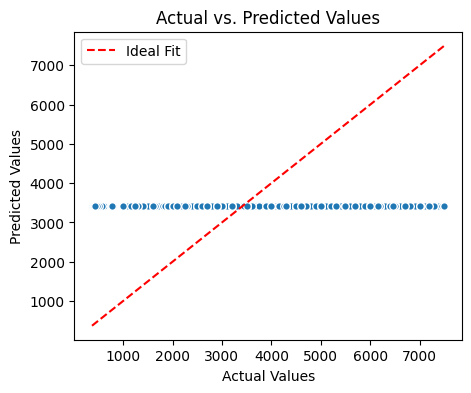

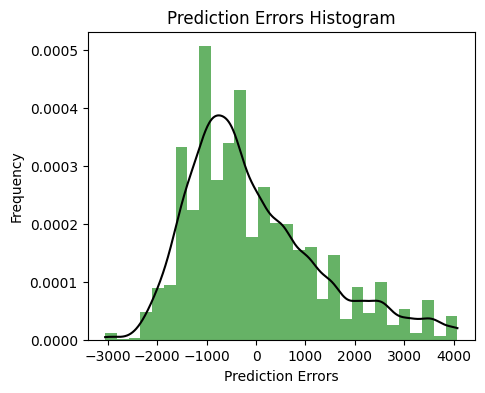

In [22]:
evaluate_model(
    true_data=np.asarray(y_test.to("cpu")).flatten(), 
    predicted_data=np.asarray(y_pred).flatten()
)